# Recursion Limit
### - The recursion limit sets the maximum number of super-steps the graph can execute during a single execution
### - Once its reaches the limit it will raise as error , GraphRecursionError
### - By default the recursion limit 25 steps


In [12]:
import operator
from typing import Annotated, Any

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]


def node_a(state):
    return {"aggregate": ["I'm A"]}


def node_b(state):
    return {"aggregate": ["I'm B"]}


def node_c(state):
    return {"aggregate": ["I'm C"]}


def node_d(state):
    return {"aggregate": ["I'm D"]}


builder = StateGraph(State)
builder.add_node("a", node_a)
builder.add_edge(START, "a")
builder.add_node("b", node_b)
builder.add_node("c", node_c)
builder.add_node("d", node_d)
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

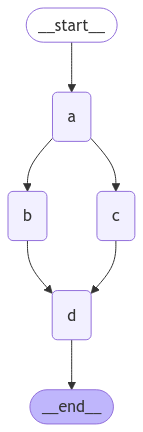

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
from langgraph.errors import GraphRecursionError

try:
    graph.invoke({"aggregate": []}, {"recursion_limit": 4})
    print("Execution done successfully")
except GraphRecursionError:
    print("Recursion Error")

Execution done successfully


## How to return state before hitting recursion limit

In [19]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph import START, END


class State(TypedDict):
    value: str
    action_result: str
    count: int


def router(state: State):
    if state["value"] == "end":
        return END
    else:
        return "action"


def decision_node(state):
    count = state["count"] + 1
    print(f"count : {count}")

    return {"value": "keep going!", "count": count}


def action_node(state: State):
    # Do your action here ...
    count = state["count"] + 1
    print(f"count : {count}")
    return {"action_result": f"what a great result!", "count": count}


workflow = StateGraph(State)
workflow.add_node("decision", decision_node)
workflow.add_node("action", action_node)
workflow.add_edge(START, "decision")
workflow.add_conditional_edges("decision", router, ["action", END])
workflow.add_edge("action", "decision")
app = workflow.compile()

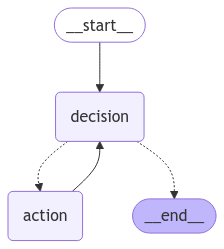

In [17]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [20]:
from langgraph.errors import GraphRecursionError

try:
    app.invoke({"value": "hi!", "count": 0})
except GraphRecursionError:
    print("Recursion Error")

count : 1
count : 2
count : 3
count : 4
count : 5
count : 6
count : 7
count : 8
count : 9
count : 10
count : 11
count : 12
count : 13
count : 14
count : 15
count : 16
count : 17
count : 18
count : 19
count : 20
count : 21
count : 22
count : 23
count : 24
count : 25
Recursion Error


In [24]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from typing import Annotated

from langgraph.managed.is_last_step import RemainingSteps


class State(TypedDict):
    value: str
    action_result: str
    remaining_steps: RemainingSteps
    count: int


def router(state: State):
    # Force the agent to end
    if state["remaining_steps"] <= 2:
        return END
    if state["value"] == "end":
        return END
    else:
        return "action"


def decision_node(state):
    count = state["count"] + 1
    return {"value": "keep going!", "count": count}


def action_node(state: State):
    # Do your action here ...
    count = state["count"] + 1
    return {"action_result": f"what a great result! {count}", "count": count}


workflow = StateGraph(State)
workflow.add_node("decision", decision_node)
workflow.add_node("action", action_node)
workflow.add_edge(START, "decision")
workflow.add_conditional_edges("decision", router, ["action", END])
workflow.add_edge("action", "decision")
app = workflow.compile()

In [25]:
app.invoke({"value": "hi!", "count": 0})

{'value': 'keep going!',
 'action_result': 'what a great result! 22',
 'count': 23}